# Events Table Stratified

__Description__: 
A Stratified sampling of runoff events is performed on a runoff distribution derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data (or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Rainfall values and probability weights for different return period events
- Max potential retention variability and distribution parameters
- Partition for the max. potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- A stratified sampling of runoff, where for each return interval the sampling includes
    - Event weight
    - Runoff value
    - Max. potential retention value
    - Rainfall value
    

__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for statified sampling; maximum return interval limit for the statified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *Temporal_Distributions* folder, containing [precipitation temporal distribution data](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) broken down by quartile for the specified volume, region, and duration.

    - The *Temporal_Distribution_Data_Map.json* which contains metadata used to extract the temporal distribution data from its *.csv file.

    - The *Temporal_Quartile_Ranks.xlsx* which contains the percentage of precipitation events whose temporal distributions are represented by those in each quartile. [Source](https://www.nws.noaa.gov/oh/hdsc/currentpf.html). 

    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: A *.csv* file containing mean incremental excess rainfall curves and a *.json* file containing the metadata associated with the curves.


#### Import Libraries

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*
import mean_frequency_curve
%matplotlib inline

In [2]:
## Excess rainfall parameters:
CN  = 81      # Curve number
mu  = 0.2  #Intial abstraction ratio parameter
PMP = 39.9   #inches, Probable Maximum Precipitation for the selected duration 

Return_Intervals = np.array([ 2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000]) #Return Intervals evaluated
RI_upper_bound = 3200 #Upper Limit of recurrence interval evaluation, Suggest not changing this value
Aerial_Reduction = 0.9216 #Aerial Reduction Factor

duration = 24   # Event duration in hour #Must be a duration in the input Precip_Table File

#Integration parameters
n_partition = 30 #Define number of partitions of max. potential retention distribution.
                 #This controls the resolution of the integration of int p(Q|S)p(S) dS

## Filenames and paths:
Project_Area = 'Amite_WA2'  # Amite_WA2Project area name
Pluvial_Model = 'P01'  # Pluvial model name
BCN =         '080702020804'   # Domain/boundary condition name

#NOAA Data
precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)
#Mean Precip Curve Data
precip_mean_curve_table = 'MeanCurve_{0}.csv'.format(Project_Area, Pluvial_Model, BCN) 

root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs'
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
precip_mean_curve_table_dir = outputs_dir/precip_mean_curve_table
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_plots = True
display_print = False
np.set_printoptions(suppress=True)

##### Convert all paths to objects:

In [3]:
inputs_dir = pl.Path(inputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
precip_mean_curve_table_dir = pl.Path(precip_mean_curve_table_dir)
datarepository_dir = pl.Path(datarepository_dir)
bin_dir = pl.Path(bin_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [4]:
## Excess rainfall parameters:
lower_limit, upper_limit = 1, 3000 

## Filenames and paths:
Temporal_Distribution_Data_Map = 'Temporal_Distribution_Data_Map.json'
Temporal_Quartile_Ranks = 'Temporal_Quartile_Ranks.xlsx'
CN_Distribution = 'NEH630_Table_10_1.json'
temporal_dir = datarepository_dir/'Temporal_Distributions'

### NOAA Atlas 14 Precipitation Values

,Median,Lower (90%),Upper (90%)
Tr,,,
1,4.278450,3.550713,5.134769
2,5.000066,4.145173,6.005280
5,6.280423,5.189506,7.559968
10,7.437209,6.111701,8.985660
25,9.169730,7.361175,11.543475
50,10.616287,8.306353,13.478353
100,12.159239,9.199587,15.756654
200,13.823333,10.044771,18.320277
500,16.175710,11.313314,21.929392


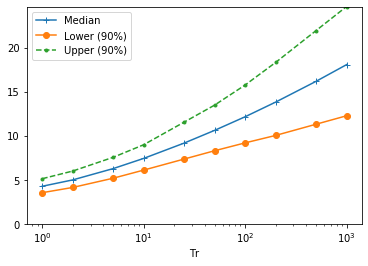

In [5]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)

raw_precip.rename(columns = {'Expected Value':'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0,raw_precip['Upper (90%)'].max() ))

raw_precip

### Fit GEV to Rainfal Data (Find GEV parameters)

In [6]:
#reduce precip by aerial reduction factor
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns] * Aerial_Reduction

#Find GEV parameter values
df_GEV_parameters_M = GEV_parameters_Fit(raw_precip_reduced, 'Median', PMP)
df_GEV_parameters_U = GEV_parameters_Fit(raw_precip_reduced, 'Upper (90%)', PMP)
df_GEV_parameters_L = GEV_parameters_Fit(raw_precip_reduced, 'Lower (90%)', PMP)

dfs = [df_GEV_parameters_M, df_GEV_parameters_L, df_GEV_parameters_U]
df_GEV_parameters = pd.concat(dfs, axis=1)
df_GEV_parameters

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.12079625082733267
            Iterations: 16
            Function evaluations: 88
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.15663906772109332
            Iterations: 13
            Function evaluations: 66
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.15606068901083595
            Iterations: 15
            Function evaluations: 84
            Gradient evaluations: 14


../../core\hydromet_stratified.py:89: RuntimeWarning:

divide by zero encountered in double_scalars



,GEV Median,GEV Lower (90%),GEV Upper (90%)
mu,4.411658,3.655686,5.377042
sigma,0.928536,0.856067,1.000000
xi,-0.178490,-0.076025,-0.259387


### Plot Fitted GEV Distribution and NOAA Data

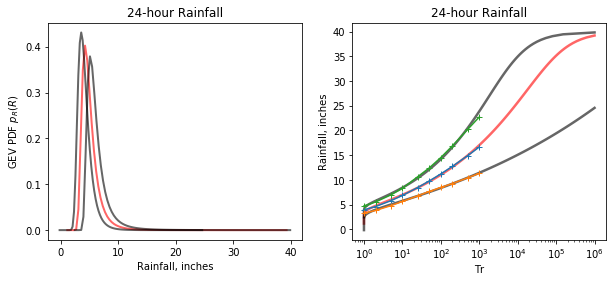

In [7]:
plot_GEV_precip_curves(raw_precip_reduced, df_GEV_parameters, PMP)

### Data for Calculating the Mean Curve

In [8]:
df_GEV_parameters
raw_precip_reduced

,Median,Lower (90%),Upper (90%)
Tr,,,
1,3.943019,3.272337,4.732203
2,4.608061,3.820192,5.534466
5,5.788038,4.782649,6.967266
10,6.854132,5.632544,8.281185
25,8.450823,6.784059,10.638467
50,9.783970,7.655135,12.421650
100,11.205955,8.478340,14.521332
200,12.739583,9.257261,16.883967
500,14.907534,10.426350,20.210128


In [9]:
#Additional Return Intervals evaluated for the mean curve
return_intervals_MC =  np.array([ 1.01, 1.05, 1.11, 1.25, 20,\
                                 2000, 5000, 10000, 20000,\
                                 50000., 100000., 200000., 1/2E-06,\
                                1/1E-06, 1/5E-07, 1/2E-07, 1/1E-07 ]) 

return_interval_data = return_interval_data(raw_precip_reduced, return_intervals_MC, df_GEV_parameters, PMP)
return_interval_data

,Median,Lower (90%),Upper (90%),Log SD (Lower),Log SD (Upper),Max Log SD,mu LN
1.00,3.943019,3.272337,4.732203,0.113339,0.110908,0.113339,1.371947
1.01,3.168932,2.419714,4.114592,0.163979,0.158751,0.163979,1.153395
1.05,3.474113,2.741810,4.410003,0.143903,0.145007,0.145007,1.245339
1.11,3.688974,2.960712,4.623850,0.133689,0.137313,0.137313,1.305348
1.25,3.988023,3.255578,4.929278,0.123359,0.128813,0.128813,1.383296
2.00,4.608061,3.820192,5.534466,0.113986,0.111360,0.113986,1.527807
5.00,5.788038,4.782649,6.967266,0.115987,0.112723,0.115987,1.755793
10.00,6.854132,5.632544,8.281185,0.119326,0.114975,0.119326,1.924852
20.00,8.048647,6.508340,9.845831,0.129130,0.122519,0.129130,2.085504
25.00,8.450823,6.784059,10.638467,0.133549,0.139947,0.139947,2.134264


### Input for Calculating the Mean Curve

In [10]:
#Confidence Limits Evaluated
CL = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, .99, 0.995, 0.999])
#Inputs for the mean curve. Table is exported as a csv
mean_curve_input_table(CL, return_interval_data, PMP, outputs_dir, Project_Area, Pluvial_Model, BCN, inputs_dir)

,0.001,0.005,0.010,0.050,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,0.950,0.990,0.995,0.999
AEP,,,,,,,,,,,,,,,,,
1.000000e-07,38.027647,38.453754,38.639133,39.073960,39.263143,39.453489,39.565378,39.645009,39.706915,39.757588,39.800495,39.837711,39.870574,39.885671,39.897192,39.898599,39.899720
2.000000e-07,37.096316,37.726650,38.002295,38.652233,38.936486,39.223395,39.392471,39.512993,39.606800,39.683656,39.748784,39.805311,39.855255,39.878209,39.895729,39.897870,39.899575
5.000000e-07,35.615958,36.559939,36.976224,37.966182,38.402867,38.845937,39.108124,39.295511,39.441645,39.561557,39.663303,39.751708,39.829894,39.865850,39.893306,39.896661,39.899334
1.000000e-06,33.637956,34.975601,35.572980,37.012180,37.655405,38.313313,38.705144,38.986338,39.206295,39.387221,39.541046,39.674933,39.793523,39.848117,39.889827,39.894926,39.898987
2.000000e-06,29.162793,31.254742,32.221987,34.640387,35.763264,36.939840,37.654445,38.173803,38.583916,38.923825,39.214662,39.469191,39.695727,39.800359,39.880448,39.890247,39.898053
5.000000e-06,21.729618,24.531465,25.921681,29.701444,31.624707,33.772549,35.150373,36.189594,37.034142,37.750910,38.376782,38.934384,39.438653,39.674166,39.855564,39.877826,39.895572
1.000000e-05,16.799462,19.581110,21.032941,25.264761,27.607106,30.408073,32.325577,33.844009,35.129112,36.259301,37.278424,38.213702,39.083301,39.497614,39.820423,39.860266,39.892062
2.000000e-05,13.386978,15.863236,17.196841,21.280495,23.695606,26.772456,29.027560,30.920087,32.610341,34.176035,35.662183,37.098218,38.505310,39.203290,39.760678,39.830338,39.886067
5.000000e-05,10.819822,12.849371,13.958674,17.452482,19.611253,22.504323,24.763534,26.783328,28.713658,30.641811,32.637520,34.773689,37.145202,38.461906,39.601027,39.749744,39.869823


### Calculate the Mean Precipitation Curve

Specified inputs_path is to a csv, loaded table.

Values increase with decreasing annual exceedance probability for all confidence limits as expected



,P_Mean_in,P_Median_in
AEP,,
0.9,3.521239,3.692303
0.5,4.724904,4.608061


C:\Users\mbartlettjr\Documents\GitHub\pfra-hydromet\Notebooks\pluvial\Outputs - already exists



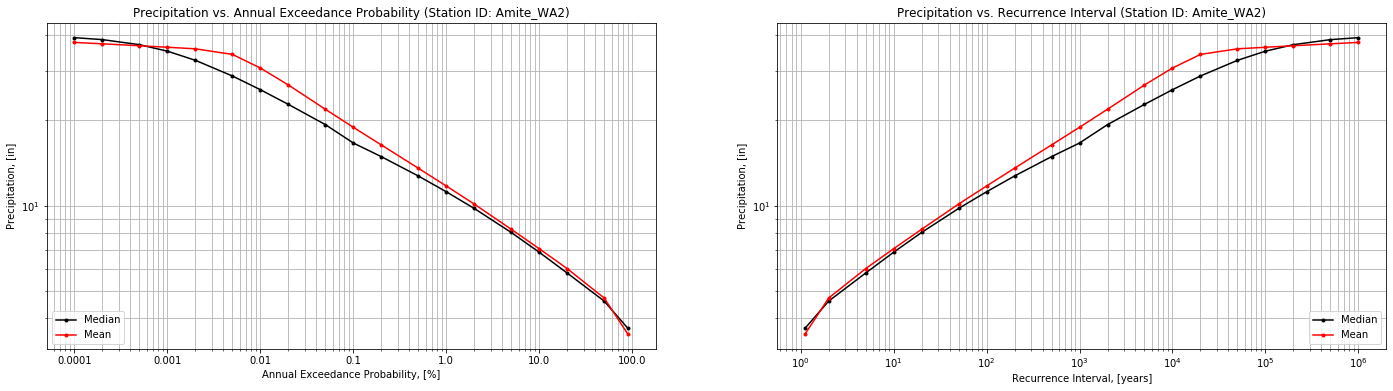

In [11]:
inputs_path= os.path.join(root_dir,'Inputs','Mean_Curve_Input_{0}_{1}_{2}.csv'.format(Project_Area, Pluvial_Model, BCN))
df = mean_frequency_curve.main(Project_Area, inputs_path, outputs_dir, data_type = 'P', round_decimals = 6)

## Hydrology 2

,P_Mean_in,P_Median_in
Tr,,
1.111111,3.521239,3.692303
2.000000,4.724904,4.608061
5.000000,5.999716,5.788038
10.000000,7.054657,6.854132
20.000000,8.261027,8.048647
50.000000,10.138923,9.783970
100.000000,11.744531,11.205955
200.000000,13.570299,12.739583
500.000000,16.398141,14.907522


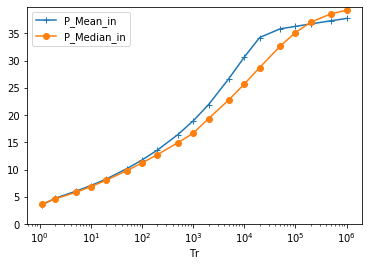

In [12]:
mean_curve_precip = pd.read_csv(precip_mean_curve_table_dir, index_col=0)

mean_curve_precip['Tr'] = 1/mean_curve_precip.index.to_numpy()
mean_curve_precip = mean_curve_precip.set_index('Tr')

mean_curve_precip.plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0, PMP))

mean_curve_precip

### Fit GEV to Mean Precipication Curve (Find GEV parameters)

In [13]:
#Find GEV parameters for the median curve
fit_values_mean_curve_precip = mean_curve_precip[1:20000] #Only fit the value up to about the 20,000 year event
df_GEV_parameters_E = GEV_parameters_Fit(fit_values_mean_curve_precip, 'P_Mean_in', PMP)
GEV_parameters_E = df_GEV_parameters_E.to_numpy().transpose()[0]

df_GEV_parameters = pd.concat([df_GEV_parameters, df_GEV_parameters_E], axis=1)
df_GEV_parameters 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.10051561292413436
            Iterations: 14
            Function evaluations: 74
            Gradient evaluations: 14


,GEV Median,GEV Lower (90%),GEV Upper (90%),GEV P_Mean_in
mu,4.411658,3.655686,5.377042,4.265670
sigma,0.928536,0.856067,1.000000,0.919047
xi,-0.178490,-0.076025,-0.259387,-0.227605


### Plot Fitted GEV Distribution and Mean Precipitation Curve

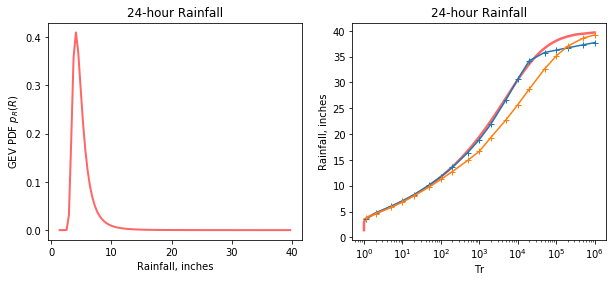

In [14]:
plot_GEV_precip_curves(mean_curve_precip, df_GEV_parameters_E, PMP)

### Hydrology 2 Events

In [15]:
#Here add in script that processes the mean curve data points that are equivalent in RI to the original NOAA data points

#Return Intervals where precipitation already is calculated for the mean precip. curve.
RI_data = np.array([ 2, 5, 10, 50, 100, 200, 500, 1000, 2000])

df_weights_rainfall = weights_Rainfall(Return_Intervals, GEV_parameters_E, PMP, RI_upper_bound, mean_curve_precip, 'P_Mean_in', RI_data , CN, mu)
df_weights_rainfall

../../core\hydromet_stratified.py:134: RuntimeWarning:

invalid value encountered in true_divide



Bin Ceiling = 3200.0, Bin Average = 3000, Bin Floor = 2818.9522203900965
Bin Ceiling = 2818.9522203900965, Bin Average = 2000, Bin Floor = 1508.128364212048
Bin Ceiling = 1508.128364212048, Bin Average = 1000, Bin Floor = 720.1134272935855
Bin Ceiling = 720.1134272935855, Bin Average = 500, Bin Floor = 370.73703983775675
Bin Ceiling = 370.73703983775675, Bin Average = 200, Bin Floor = 127.48099903773436
Bin Ceiling = 127.48099903773436, Bin Average = 100, Bin Floor = 80.88346243346972
Bin Ceiling = 80.88346243346972, Bin Average = 50, Bin Floor = 34.40699526296626
Bin Ceiling = 34.40699526296626, Bin Average = 25, Bin Floor = 19.11854908668659
Bin Ceiling = 19.11854908668659, Bin Average = 10, Bin Floor = 6.286259035980243
Bin Ceiling = 6.286259035980243, Bin Average = 5, Bin Floor = 4.092622076393614
Bin Ceiling = 4.092622076393614, Bin Average = 2, Bin Floor = 1.2580388308092747


,Bin Floor,Bin Celing,Event Weight,P_Mean_in,Runoff
2.0,1.258039,4.092622,0.550546,4.724904,2.743575
5.0,4.092622,6.286259,0.085265,5.999716,3.883483
10.0,6.286259,19.118549,0.106772,7.054657,4.855908
25.0,19.118549,34.406995,0.023241,8.587985,6.298966
50.0,34.406995,80.883462,0.016700,10.138923,7.782035
100.0,80.883462,127.480999,0.004519,11.744531,9.333665
200.0,127.480999,370.737040,0.005147,13.570299,11.111687
500.0,370.737040,720.113427,0.001309,16.398141,13.884410
1000.0,720.113427,1508.128364,0.000726,18.923549,16.373262
2000.0,1508.128364,2818.952220,0.000308,21.910057,19.326558


# Hydrology 3
### Retreive Max. Potential Retention Variability and Distribution Parameters

In [16]:
#NRCS value of wet and dry soil moiture conditions
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

#Table of wet, dry, and average (or median) soil moisture conditions
df_CN = prep_cn_table(CN, arc_data)  

#Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion
fitted_cn = find_optimal_curve_beta_dist_S(df_CN)

#Distribution parameter values
S_limit = 1000/fitted_cn.iloc[0]['CN Lower Limit']-10
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']

#Define Probability for each partition of the max. potential retention distribution.
Delta_P=1/n_partition

#Find the average value over each partition, which is the basis for the runoff distribution
partition_avg = partition_S_avgs(n_partition, alpha, beta, S_limit)
print(partition_avg )

fitted_cn['mu']= mu
fitted_cn

[0.23376944 0.52727771 0.76140187 0.97232688 1.16985429 1.35865859
 1.54147283 1.72010061 1.89583845 2.06968314 2.24244615 2.41482256
 2.58743654 2.76087373 2.93570679 3.11251785 3.29192032 3.47458285
 3.66125786 3.8528184  4.05030875 4.2550179  4.46859172 4.69321457
 4.93192328 5.18919747 5.47220288 5.79388777 6.18325529 6.76378274]


,AMC I (Dry),AMC II,AMC III (Wet),alpha,beta,CN Lower Limit,Fitted AMC I (Dry),Fitted AMC II,Fitted AMC III (Wet),mu
1,64,81,92,1.452024,1.981606,57.339798,63.999873,80.999205,91.999302,0.2


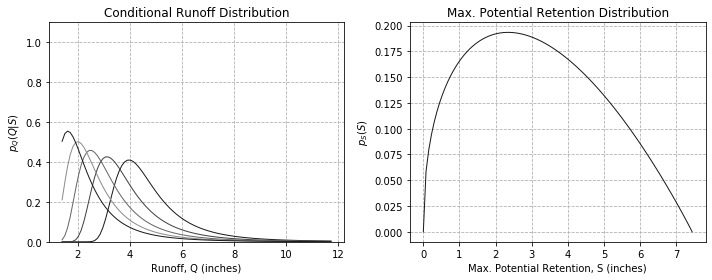

In [17]:
plot_runoff_maxRetention_distributions(GEV_parameters_E, PMP, fitted_cn)

## Runoff as a function of the return period

In [18]:
#error between the integral approach (based on summation integration) and the actual value
error_PQ = 1- CDF_Q(PMP, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P)

#Print Results
print('\n'
      'Probability of zero runoff = %s \n' 
      'Error in calculation of Probabilibity of zero runoff = %s \n'
      'Error, i.e., the difference  between 1 and the numerical CDF evaluated at PMP,  Error = %s'
      %(P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP)[0], P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP)[1], error_PQ ))

#Time the integration
#  %timeit CDF_Q( 3 , 0.2, alpha, beta, S_limit, GEV_parameters_E)


Probability of zero runoff = 2.2769742293802964e-78 
Error in calculation of Probabilibity of zero runoff = 4.453101367348324e-78 
Error, i.e., the difference  between 1 and the numerical CDF evaluated at PMP,  Error = -1.291255324220586e-05


### Determine Runoff Values and Weights
- Runoff weights calculated starting from a given bin ceiling.

In [19]:
#tck_RI_Q, tck_Q_RI respectively are cubic spline interpolation functions for runoff as a function of return period and return period as a function of runoff, respectively.
f_RI_Q, f_Q_RI, df_weights_runoff = runoff(Return_Intervals, RI_upper_bound, mu, GEV_parameters_E, PMP, alpha, beta, S_limit, partition_avg, Delta_P, error_PQ)
df_weights_runoff

Bin Ceiling = 3200.0, Bin Floor 2819.585856802129
Bin Ceiling = 2819.585856802129, Bin Floor 1506.074059234115
Bin Ceiling = 1506.074059234115, Bin Floor 720.017690135344
Bin Ceiling = 720.017690135344, Bin Floor 370.5316747251796
Bin Ceiling = 370.5316747251796, Bin Floor 127.37434061224587
Bin Ceiling = 127.37434061224587, Bin Floor 80.9336182548409
Bin Ceiling = 80.9336182548409, Bin Floor 8.051383292948948


../../core\hydromet_stratified.py:200: RuntimeWarning:

invalid value encountered in true_divide



Bin Ceiling = 8.051383292948948, Bin Floor 1.430856811904238
Bin Ceiling = 1.430856811904238, Bin Floor 1.4308568119042346
Bin Ceiling = 1.4308568119042346, Bin Floor 1.0105943687050432
Bin Ceiling = 1.0105943687050432, Bin Floor 1.0105943342107946


,Bin Floor,Bin Celing,Event Weight,Runoff
2,1.010594,1.010594,3.377481e-08,2.778297
5,1.010594,1.430857,2.906347e-01,3.927825
10,1.430857,1.430857,1.665335e-15,4.866046
25,1.430857,8.051383,5.746797e-01,6.320163
50,8.051383,80.933618,1.118465e-01,7.644756
100,80.933618,127.374341,4.504930e-03,9.209197
200,127.374341,370.531675,5.152050e-03,11.055197
500,370.531675,720.017690,1.309970e-03,14.001690
1000,720.017690,1506.074059,7.248768e-04,16.664400
2000,1506.074059,2819.585857,3.093160e-04,19.722735


### Plot runoff distribution

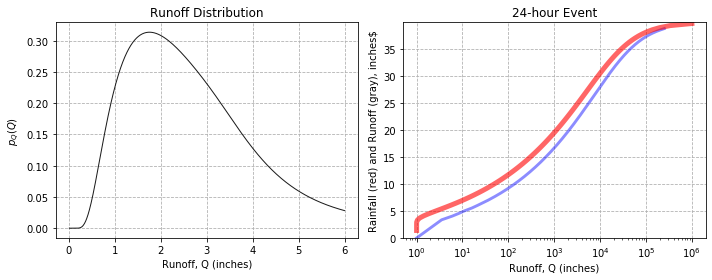

In [20]:
plot_runoff_distributions_final(GEV_parameters_E, PMP, fitted_cn, partition_avg, Delta_P, f_RI_Q)

### Plot maximum potential distribution conditional on runoff

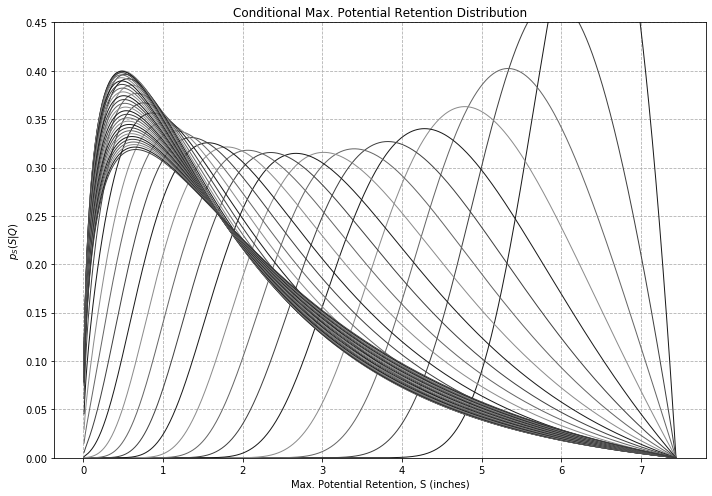

In [21]:
plot_max_potential_retention_cond_runoff(GEV_parameters_E, PMP, fitted_cn, partition_avg, Delta_P)

### Calculate Runoff and Corresponding Max. Potential Retention and Rainfall

In [22]:
df_runoff_SR1 = Scenarios_Avg_S_Median_S(df_weights_runoff, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit)
df_runoff_SR1

Calculating Median S for Runoff = 2.7782967702770267
Calculating Median S for Runoff = 3.9278252036621026
Calculating Median S for Runoff = 4.866046089992782
Calculating Median S for Runoff = 6.320162700068181
Calculating Median S for Runoff = 7.644756378266523
Calculating Median S for Runoff = 9.209197227132554
Calculating Median S for Runoff = 11.055196856577174
Calculating Median S for Runoff = 14.001689686613128
Calculating Median S for Runoff = 16.664400415427462
Calculating Median S for Runoff = 19.72273476219037
Calculating Median S for Runoff = 21.685857182764963
Calculating Median S for Runoff = 26.917277769382505


,Bin Floor,Bin Celing,Event Weight,Runoff,Avg. S,Rainfall,Median S,Rainfall
2,1.010594,1.010594,3.377481e-08,2.778297,2.551529,4.902559,2.286557,4.724387
5,1.010594,1.430857,2.906347e-01,3.927825,1.902649,5.710482,1.552846,5.429836
10,1.430857,1.430857,1.665335e-15,4.866046,1.825328,6.645391,1.443528,6.319488
25,1.430857,8.051383,5.746797e-01,6.320163,1.894873,8.225421,1.507815,7.879308
50,8.051383,80.933618,1.118465e-01,7.644756,1.988400,9.680041,1.611360,9.333969
100,80.933618,127.374341,4.504930e-03,9.209197,2.090634,11.383181,1.728991,11.043422
200,127.374341,370.531675,5.152050e-03,11.055197,2.192367,13.368192,1.846693,13.036258
500,370.531675,720.017690,1.309970e-03,14.001690,2.319376,16.491736,1.995837,16.172522
1000,720.017690,1506.074059,7.248768e-04,16.664400,2.407376,19.279956,2.100434,18.971291
2000,1506.074059,2819.585857,3.093160e-04,19.722735,2.487118,22.454217,2.199480,22.159860


## Hydrology 3 Events
- For each runoff value, two events are considered, a high max. potential retention, and a low max. potential retention

In [23]:
df_runoff_SR2 = Scenarios_low_and_high_S(df_runoff_SR1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha,beta,S_limit)
df_runoff_SR2

,Event Weight,Runoff,Avg. S (Lower 50%),Rainfall,Event Weight,Runoff,Avg. S (Upper 50%),Rainfall
2,1.688741e-08,2.778297,1.451966,4.121615,1.688741e-08,2.778297,3.651092,5.594069
5,1.453174e-01,3.927825,0.809980,4.778910,1.453174e-01,3.927825,2.995317,6.515448
10,8.326673e-16,4.866046,0.722533,5.649253,8.326673e-16,4.866046,2.928123,7.509525
25,2.873398e-01,6.320163,0.749702,7.147254,2.873398e-01,6.320163,3.040044,9.171763
50,5.592323e-02,7.644756,0.805958,8.541193,5.592323e-02,7.644756,3.170842,10.689595
100,2.252465e-03,9.209197,0.872329,10.186076,2.252465e-03,9.209197,3.308940,12.454920
200,2.576025e-03,11.055197,0.939732,12.114237,2.576025e-03,11.055197,3.445001,14.501495
500,6.549849e-04,14.001690,1.026802,15.167913,6.549849e-04,14.001690,3.611949,17.702474
1000,3.624384e-04,16.664400,1.088906,17.907947,3.624384e-04,16.664400,3.725846,20.545348
2000,1.546580e-04,19.722735,1.149675,21.042161,1.546580e-04,19.722735,3.824561,23.766955


---